In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ECG-Classification')

In [ ]:
!pip install PyWavelets
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [ ]:
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
import os

base_path = "./data/mit-bih-arrhythmia-database-1.0.0/"

def Denoising(file_number):
    #用db5作为小波基，对心电数据进行9尺度小波变换
    record = wfdb.rdrecord(os.path.join(base_path,file_number), channel_names=['MLII'])
    signal = record.p_signal.flatten()

    # 小波变换
    coeffs = pywt.wavedec(data=signal, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs
    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)
    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')

    return rdata

In [ ]:
# 读取心电数据和对应标签,并对数据进行小波去噪

label_categories_code = {}

def GetData(file_number, X_data, Y_data):
    # 读取心电数据记录
    print("正在读取 " + file_number+ " 号心电数据")
    # 小波去噪
    rdata = Denoising(file_number)
    # 获取心电数据记录中R波的位置和对应的标签
    annotation=annotation = wfdb.rdann(os.path.join(base_path,file_number), 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol
    rdata_length=len(rdata)
    # 因为只选择NSVFQ五种心电类型,所以要选出该条记录中所需要的那些带有特定标签的数据,舍弃其余标签的点
    # X_data在R波前后截取长度为300的数据点
    # Y_data将NAVLR按顺序转换为01234
    for i in range(len(annotation.symbol)) :
            if Rlocation[i]<100 or Rlocation[i]>rdata_length-200:
                continue
            else :
                Subcategory.add(Rclass[i])
                key = ''
                for item in EcgClassSet.items():
                    if Rclass[i] in item[1]:
                        key = item[0]
                if key == '':
                    continue
                lable = Classset.index(key)
                label_categories_code[key] = lable

                x_train = rdata[Rlocation[i] - 100:Rlocation[i] + 200]

                #z分数归一化  无显著影响
                #mu = x_train.mean()
                #std = x_train.std()
                #for i in range(len(x_train)):
                #    x_train[i] = (x_train[i] - mu) / std

                X_data.append(x_train)
                Y_data.append(lable)

In [ ]:
Subcategory = set()

# 五大类里面的小分支
N = ['N', 'L', 'R', 'e', 'j']
S = ['A', 'a', 'J', 'S']
V = ['V', 'E']
F = ['F']
Q = ['/', 'f', 'Q']
# 五大类
Classset = ['N', 'S', 'V', 'F', 'Q']
EcgClassSet = {'N': N, 'S': S, 'V': V, 'F': F, 'Q': Q}

file_numbers = [100, 101, 103, 105, 106, 107,108, 109, 111, 112,113, 114, 115, 116,
                117, 118, 119, 121, 122,123, 124, 200, 201, 202, 203, 205, 207, 208,
                209, 210, 212, 213, 214, 215,217, 219, 220, 221,222, 223, 228, 230,
                231, 232, 233, 234]

dataSet=[]
labelSet=[]

for file_number in file_numbers:
    GetData(str(file_number), dataSet, labelSet)
dataSet = np.array(dataSet).reshape(-1, 300)
lableSet = np.array(labelSet).reshape(-1, 1)
train_ds = np.hstack((dataSet, lableSet))
np.random.shuffle(train_ds)

正在读取 100 号心电数据
正在读取 101 号心电数据
正在读取 103 号心电数据
正在读取 105 号心电数据
正在读取 106 号心电数据
正在读取 107 号心电数据
正在读取 108 号心电数据
正在读取 109 号心电数据
正在读取 111 号心电数据
正在读取 112 号心电数据
正在读取 113 号心电数据
正在读取 114 号心电数据
正在读取 115 号心电数据
正在读取 116 号心电数据
正在读取 117 号心电数据
正在读取 118 号心电数据
正在读取 119 号心电数据
正在读取 121 号心电数据
正在读取 122 号心电数据
正在读取 123 号心电数据
正在读取 124 号心电数据
正在读取 200 号心电数据
正在读取 201 号心电数据
正在读取 202 号心电数据
正在读取 203 号心电数据
正在读取 205 号心电数据
正在读取 207 号心电数据
正在读取 208 号心电数据
正在读取 209 号心电数据
正在读取 210 号心电数据
正在读取 212 号心电数据
正在读取 213 号心电数据
正在读取 214 号心电数据
正在读取 215 号心电数据
正在读取 217 号心电数据
正在读取 219 号心电数据
正在读取 220 号心电数据
正在读取 221 号心电数据
正在读取 222 号心电数据
正在读取 223 号心电数据
正在读取 228 号心电数据
正在读取 230 号心电数据
正在读取 231 号心电数据
正在读取 232 号心电数据
正在读取 233 号心电数据
正在读取 234 号心电数据


In [ ]:
import pandas as pd
df = pd.DataFrame(train_ds)

# 类别标签数量分布
df[300].value_counts().sort_index()

,count
300,
0.0,90327
1.0,2781
2.0,7229
3.0,802
4.0,3894


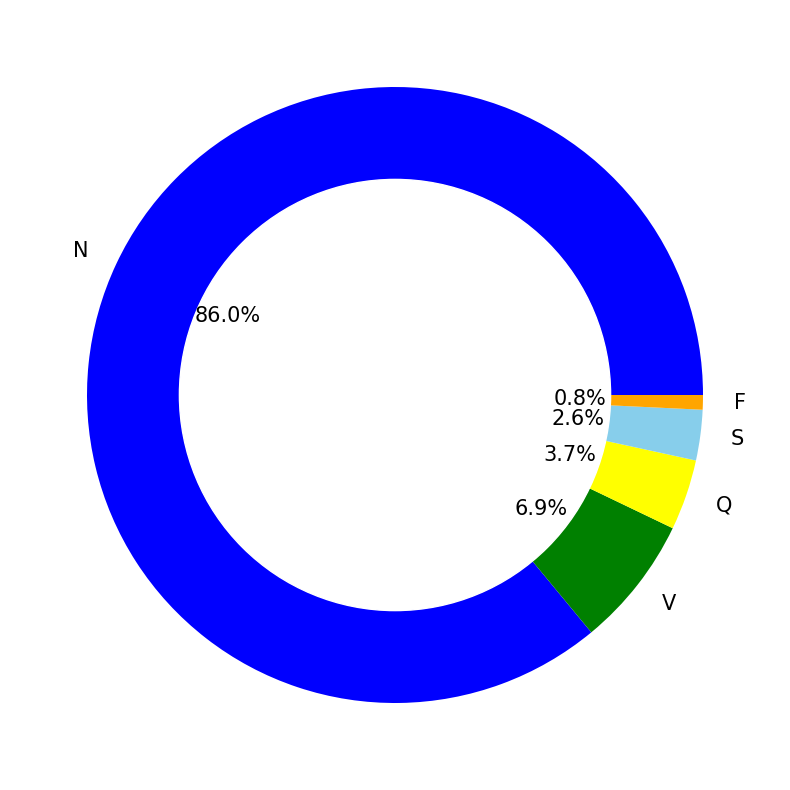

In [ ]:
equilibre = df[300].value_counts()
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(equilibre, labels=["N","V","Q","S","F"], colors=['Blue','Green','Yellow','Skyblue','Orange'],autopct='%1.1f%%', textprops={'color': 'black', 'fontsize': 15})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig('./result/OringinDataDistribution1.jpeg', format='jpeg',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# 各个类别分别挑选一条数据
classes = df.groupby(300, group_keys=False).apply(lambda df: df.sample(1))
classes

<ipython-input-12-53049157>:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  classes = df.groupby(300, group_keys=False).apply(lambda df: df.sample(1))


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
99425,-0.498309,-0.500328,-0.502098,-0.503203,-0.503629,-0.503051,-0.502609,-0.503145,-0.504144,-0.505903,...,-0.501944,-0.506010,-0.509714,-0.513611,-0.518041,-0.522657,-0.527518,-0.532135,-0.536023,0.0
27106,-0.117197,-0.115024,-0.113587,-0.114220,-0.116560,-0.121464,-0.125973,-0.127777,-0.128314,-0.126847,...,-0.178437,-0.178909,-0.179973,-0.181009,-0.181329,-0.181324,-0.180826,-0.179926,-0.178835,1.0
49687,-0.151042,-0.150098,-0.149132,-0.147848,-0.146519,-0.145220,-0.143533,-0.141267,-0.138439,-0.134888,...,-0.187075,-0.189380,-0.191069,-0.192639,-0.194703,-0.196559,-0.198137,-0.199535,-0.200568,2.0
75388,-0.430649,-0.433062,-0.436523,-0.440096,-0.444298,-0.449106,-0.454165,-0.460648,-0.469108,-0.476883,...,-0.118640,-0.283532,-0.429619,-0.554036,-0.631849,-0.643892,-0.645315,-0.668246,-0.690119,3.0
98773,-0.570055,-0.570577,-0.571277,-0.572107,-0.573011,-0.573928,-0.574800,-0.575555,-0.576209,-0.576751,...,-0.681193,-0.683164,-0.684422,-0.685428,-0.686070,-0.686256,-0.686090,-0.685221,-0.683451,4.0


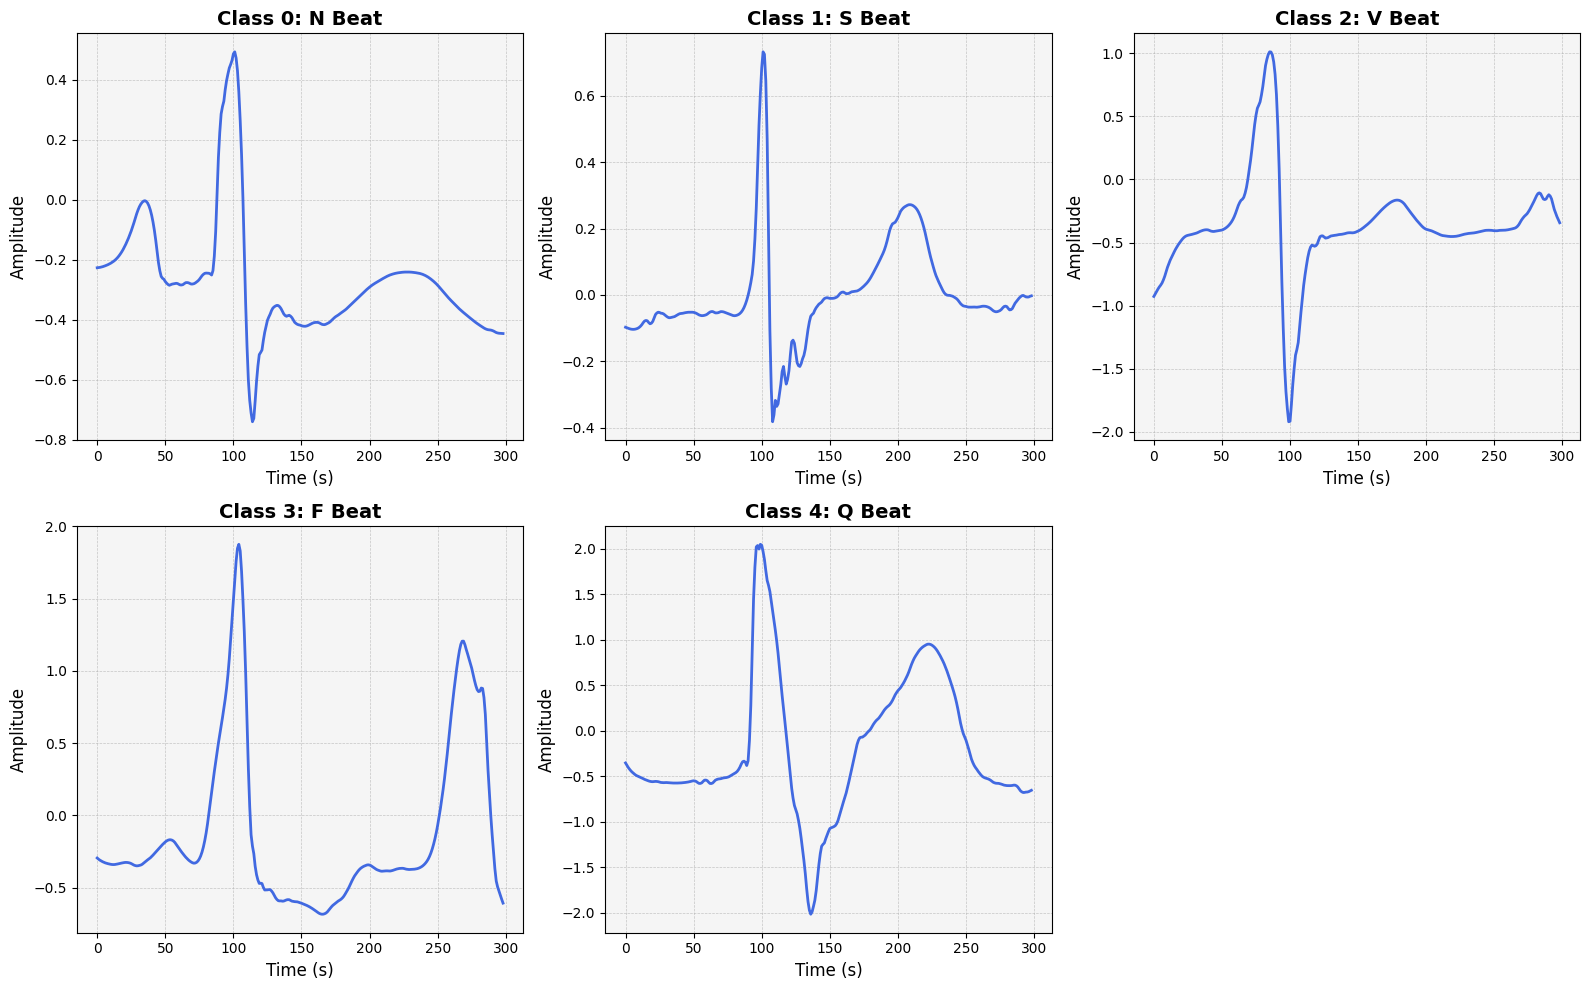

In [ ]:
# 绘制各个列别的ECG信号图
# plotting classes ECG
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(16, 10))

# 通过定义一个函数来重复绘制过程，减少冗余代码
def plot_ecg_signal(ax, data, title, color='blue'):
    ax.plot(data, color=color, linewidth=2)  # 设置线条宽度
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Amplitude", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # 添加网格
    ax.tick_params(axis='both', labelsize=10)
    ax.set_facecolor('whitesmoke')  # 设置背景颜色

# normal
ax1 = plt.subplot(2, 3, 1)
plot_ecg_signal(ax1, classes.iloc[0, :299], "Class 0: N Beat", color='royalblue')

# unknown
ax2 = plt.subplot(2, 3, 2)
plot_ecg_signal(ax2, classes.iloc[1, :299], "Class 1: S Beat", color='royalblue')

# veb
ax3 = plt.subplot(2, 3, 3)
plot_ecg_signal(ax3, classes.iloc[2, :299], "Class 2: V Beat", color='royalblue')

# seb
ax4 = plt.subplot(2, 3, 4)
plot_ecg_signal(ax4, classes.iloc[3, :299], "Class 3: F Beat", color='royalblue')

# fusion
ax5 = plt.subplot(2, 3, 5)
plot_ecg_signal(ax5, classes.iloc[4, :299], "Class 4: Q Beat", color='royalblue')

# 调整布局，避免重叠
plt.tight_layout()
# 保存图像到本地
plt.savefig('./result/Examples of ECG signals from the 5-class MIT-BIH dataset.jpeg', format='jpeg',dpi=300, bbox_inches='tight')  # 设置 dpi 为 300，高质量保存
plt.show()

In [ ]:
# 测试集在数据集中所占的比例
RATIO = 0.15


# 数据集及其标签集
X = train_ds[:, :300]
Y = train_ds[:, 300]

# 测试集及其标签集
shuffle_index = np.random.permutation(len(X))

test_length = int(RATIO * len(shuffle_index))
# 测试集的长度
test_index = shuffle_index[:test_length]
# 训练集的长度
train_index = shuffle_index[test_length:]

X_test, Y_test = X[test_index], Y[test_index]
X_train, Y_train = X[train_index], Y[train_index]

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

borderline_smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)
X_train_resample, Y_train_resample = borderline_smote.fit_resample(X_train, Y_train)

In [ ]:
# 查看GPU是否可用
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# 指定GPU训练
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8059336028187232734
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1163230544845521136
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


(383940, 300, 1)
(15754, 300, 1)


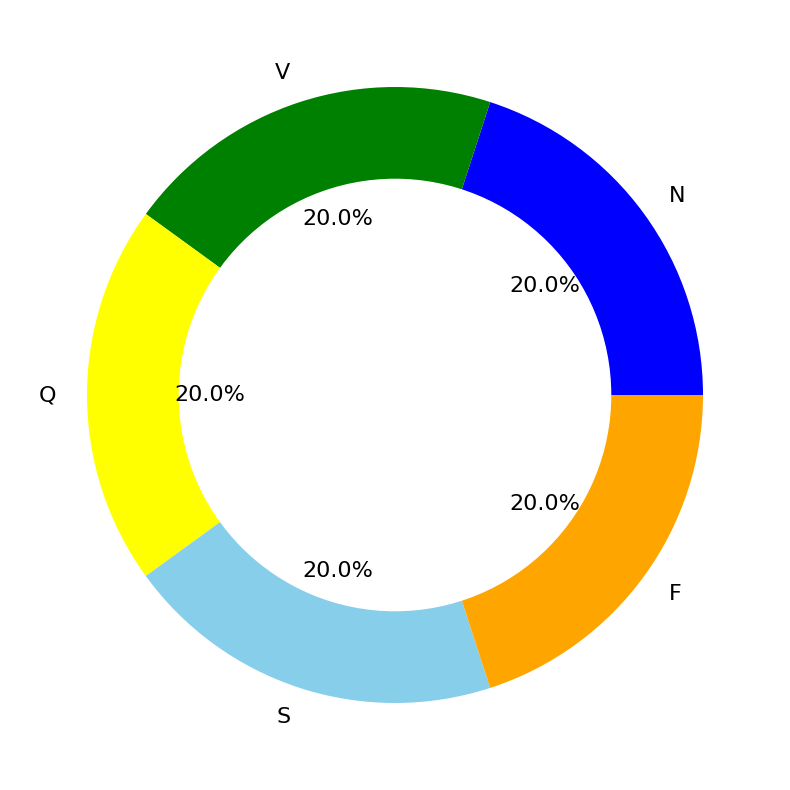

训练集类别分布： 0
0.0    76788
1.0    76788
2.0    76788
3.0    76788
4.0    76788
Name: count, dtype: int64
测试集类别分布： 0
0.0    13539
1.0      429
2.0     1080
3.0      134
4.0      572
Name: count, dtype: int64


In [ ]:
print(X_train_resample.shape)
print(X_test.shape)

equilibre = pd.DataFrame(Y_train_resample)[0].value_counts()
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=["N","V","Q","S","F"], colors=['Blue','Green','Yellow','Skyblue','Orange'],autopct='%1.1f%%', textprops={'color': 'black', 'fontsize': 16})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig('./result/Distribution of heartbeats in five classes of the MIT-BIH dataset.jpeg', format='jpeg',dpi=300, bbox_inches='tight')
plt.show()

print("训练集类别分布：", pd.DataFrame(Y_train_resample)[0].value_counts().sort_index())
print("测试集类别分布：", pd.DataFrame(Y_test)[0].value_counts().sort_index())

X_train_resample = X_train_resample.reshape(-1, 300, 1)
X_test = X_test.reshape(-1, 300, 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# 定义注意力机制层
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="attention_weights", shape=(input_shape[-1], 1), initializer="random_normal")
        self.b = self.add_weight(name="attention_bias", shape=(1,), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # 计算注意力得分
        score = tf.matmul(inputs, self.W) + self.b
        attention_weights = tf.nn.softmax(score, axis=1)

        # 对每个时间步的隐藏状态加权求和
        weighted_sum = inputs * attention_weights
        return tf.reduce_sum(weighted_sum, axis=1)

# CNN-BiGRU+Attention模型
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),

        # 第一个卷积层，4 个 21x1 卷积核
        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='same', activation='tanh'),
        # 第一个池化层，最大池化，4 个 3x1 卷积核，步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),

        # 第二个卷积层，16 个 23x1 卷积核
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='same', activation='relu'),
        # 第二个池化层，最大池化，4 个 3x1 卷积核，步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),

        # 第三个卷积层，32 个 25x1 卷积核
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='same', activation='tanh'),
        # 第三个池化层，平均池化，4 个 3x1 卷积核，步长为 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='same'),

        # 第四个卷积层，64 个 27x1 卷积核
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='same', activation='relu'),

        # 双向GRU层
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),

        # 添加自定义注意力层
        AttentionLayer(),

        # 打平层，方便全连接层处理
        tf.keras.layers.Flatten(),

        # 全连接层，128 个节点，转换成128个节点
        tf.keras.layers.Dense(128, activation='relu'),

        # Dropout层，dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),

        # 全连接层，5 个节点
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    return newModel


In [ ]:
model = buildModel()
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 300, 4)              │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 150, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 150, 16)             │           1,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 75, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 75, 32)              │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 38, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 38, 64)              │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 38, 128)             │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 128)                 │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,974 (535.05 KB)

 Trainable params: 136,974 (535.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train_resample, Y_train_resample, epochs=30, batch_size=128, validation_split=RATIO, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9250 - loss: 0.2887 - val_accuracy: 0.9754 - val_loss: 0.0895
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9764 - loss: 0.0875 - val_accuracy: 0.9837 - val_loss: 0.0600
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9837 - loss: 0.0605 - val_accuracy: 0.9866 - val_loss: 0.0505
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9862 - loss: 0.0490 - val_accuracy: 0.9859 - val_loss: 0.0514
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9884 - loss: 0.0403 - val_accuracy: 0.9892 - val_loss: 0.0396
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9880 - loss: 0.0388 - val_accuracy: 0.9895 - val_loss: 0.0404
Epoch 7/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9902 - loss: 0.0328 - val_accuracy: 0.9896 - val_loss: 0.0370
Epoch 8/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9914 - loss: 0.0274 - val_accuracy: 

In [ ]:
# 预测
from sklearn.metrics import classification_report

Y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(Y_pred, Y_test,target_names=['N', 'S', 'V', 'F', 'Q'],digits=4))

493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           N     0.9967    0.9956    0.9961     13492
           S     0.9137    0.9538    0.9333       433
           V     0.9772    0.9815    0.9793      1134
           F     0.8889    0.8302    0.8585       106
           Q     0.9966    0.9932    0.9949       589

    accuracy                         0.9922     15754
   macro avg     0.9546    0.9508    0.9524     15754
weighted avg     0.9923    0.9922    0.9922     15754



493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


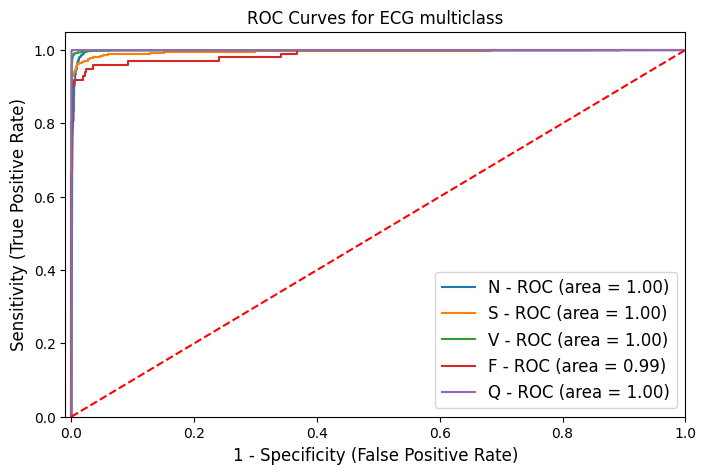

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve,auc
from itertools import cycle
from sklearn.preprocessing import OneHotEncoder


y_scores = model.predict(X_test)
y_test = label_binarize(Y_test, classes=[0,1,2,3,4])
n_classes = 5

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,5))

label = ['N', 'S', 'V', 'F', 'Q']
colors = cycle(['Blue','Green','Yellow','Skyblue','Orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], label='%s - ROC (area = %0.2f)' % (label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC Curves for ECG multiclass', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("./result/roc_20250318.jpeg", format='jpeg', dpi=300, bbox_inches='tight')
plt.show()



Confusion Matrix:
 [[13432    19    11    13     2]
 [   35   413     4     0     0]
 [   18     1  1113     5     2]
 [    5     0     6    88     0]
 [    2     0     0     0   585]]


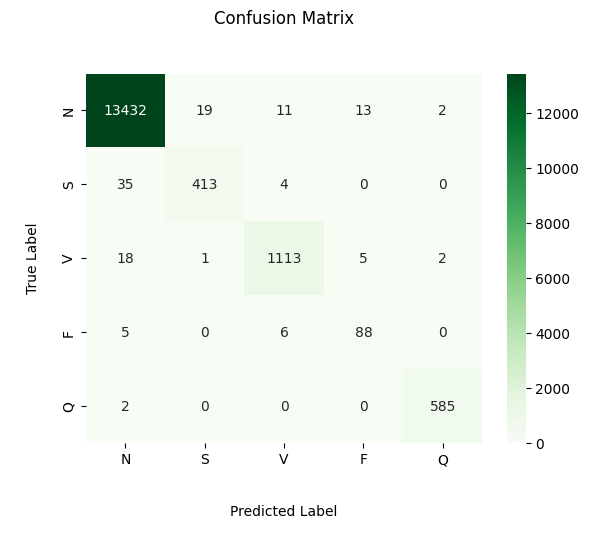

In [ ]:
import seaborn as sns
cm = confusion_matrix(Y_test, Y_pred)
print("\n\nConfusion Matrix:\n", cm)


test_c = ['N', 'S', 'V', 'F', 'Q']
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.savefig("./result/Confusion_Matrix_20250318.jpeg", format='jpeg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import recall_score, classification_report
# 计算敏感度
sensitivity = recall_score(Y_test, Y_pred, average='macro')
print(f"sensitivity: {sensitivity}")

# 计算特异度
cm = confusion_matrix(Y_test, Y_pred)
print(cm)
specificity = []
for i in range(len(cm)):
    TN = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    FP = np.sum(cm[:, i]) - cm[i, i]
    specificity.append(TN / (TN + FP))

print(f"specificity: {specificity}")
mro_specificity = sum(specificity)/len(specificity)
print(mro_specificity)

sensitivity: 0.954606496944163
[[13432    19    11    13     2]
 [   35   413     4     0     0]
 [   18     1  1113     5     2]
 [    5     0     6    88     0]
 [    2     0     0     0   585]]
specificity: [np.float64(0.9736495388669302), np.float64(0.9986929813096327), np.float64(0.9985631200821075), np.float64(0.9988502076014053), np.float64(0.9997362695325377)]
0.9938984234785228


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_26']
Received: inputs=Tensor(shape=(32, 300, 1))
  warnings.warn(msg)


463/493 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_26']
Received: inputs=Tensor(shape=(None, 300, 1))
  warnings.warn(msg)


493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


<ipython-input-34-2be985f09659>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', 10)  # 使用另一种颜色映射表


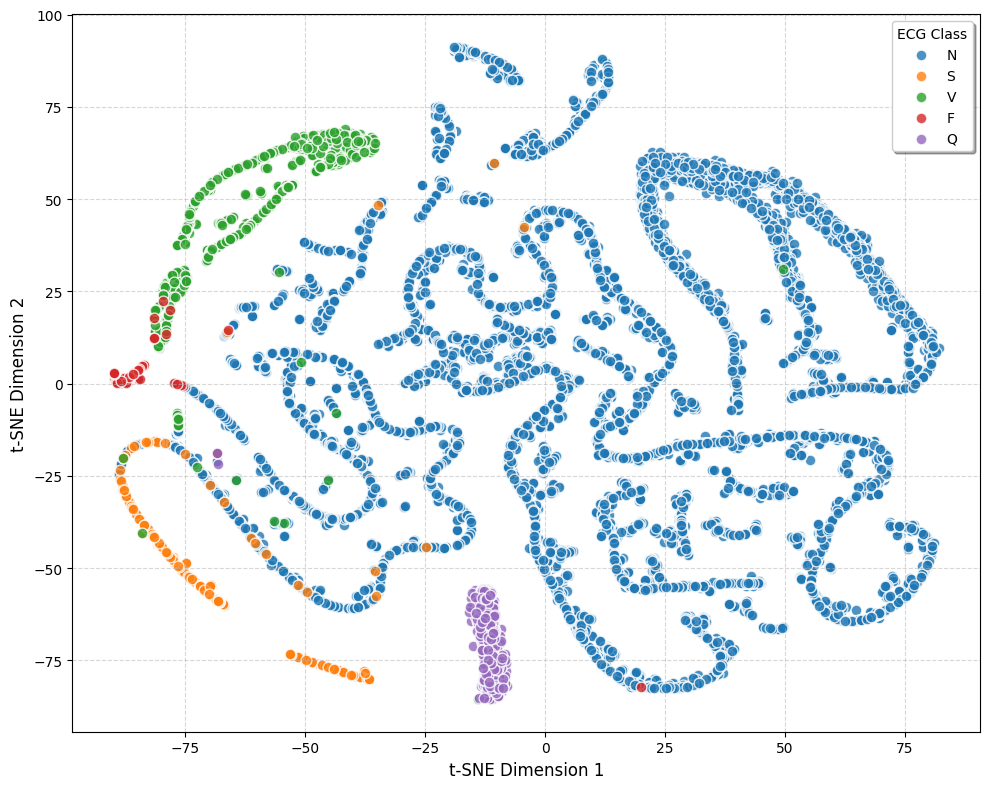

In [ ]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE


# 获取特征层输出
representation_model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
feature_layer_output = representation_model.predict(X_test)
flattened_output = feature_layer_output.reshape(feature_layer_output.shape[0], -1)

# 初始化TSNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)

# 特征层输出降维
X_tsne = tsne.fit_transform(flattened_output)
y = np.argmax(y_test, axis=1)

# 可视化
# 设置颜色和图形风格
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('viridis', 10)  # 使用另一种颜色映射表
for label in np.unique(y):
    indices = y == label
    plt.scatter(
        X_tsne[indices, 0],
        X_tsne[indices, 1],
        label=f'Digit {label}',
        s=60, alpha=0.8, edgecolor='white'
    )

# 添加图例
plt.legend(title="ECG Class", loc='best', labels=['N', 'S', 'V', 'F', 'Q'], fontsize=10, frameon=True, shadow=True, fancybox=True)

# 添加标题和标签
plt.title('', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

# 优化显示效果
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("./result/t-SNE_%s.jpeg" % layer_name, format='jpeg', dpi=300, bbox_inches='tight')
# 显示图形
plt.show()